In [96]:
from gaussian_fermions import * #Can be installed with pip install gaussian_fermions

L = 20 #System length
N_shots = 1e4 #Whether to include Gaussian noise
N = 10 #Number of evolution times
T = 15 #Evolution time
beta = 3 #Inverse temperature

# (a) Create a thermal state
H_nnh = nearest_neighbor_hopping( L )
cov_thermal = H_nnh.cov_thermal( beta )

# (b) Double up the lattice
cov_ini =  np.kron( cov_thermal, [ [ 0, 0 ], [ 0, 1 ] ] ) 

# (c) Quench to NN and evolve to equidistant times
H_quench = nearest_neighbor_hopping( 2 * L )
times = np.linspace( 0, T, N )

# (d) Measure local particle numbers
if N_shots != 0:
    sigma = 1. / np.sqrt( N_shots / N )
else:
    sigma = 0
    
data = [ H_quench.cov_evolve( cov_ini, t ).real.diagonal(0) + np.random.normal( 0, sigma, 2*L ) for t in times ]

## Run tomography
#
from hopping_tomography import * #Source: https://github.com/marekgluza/hopping_tomography

tomography = hopping_tomography( data, times, H_quench ) #Create an object using particle number data, times, and the model
tomography.recover_SDP( SDP_constraints = True, verbose = True ) #, eps = 1e-5, max_iters = 2500 )


----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1165610
eps = 1.00e-05, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 3610, constraints m = 8090
Cones:	soc vars: 1610, soc blks: 410
	sd vars: 6480, sd blks: 2
Setup time: 1.92e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.87e+20  3.96e+20  9.63e-01 -5.57e+21 -1.05e+20  4.45e+21  3.02e-02 
   100| 9.57e-04  1.68e-03  2.63e-04  9.22e-01  9.22e-01  2.87e-16  3.11e+00 
   200| 8.26e-06  1.40e-05  3.18e-06  9.23e-01  9.23e-01  2.86e-16  6.48e+00 
  

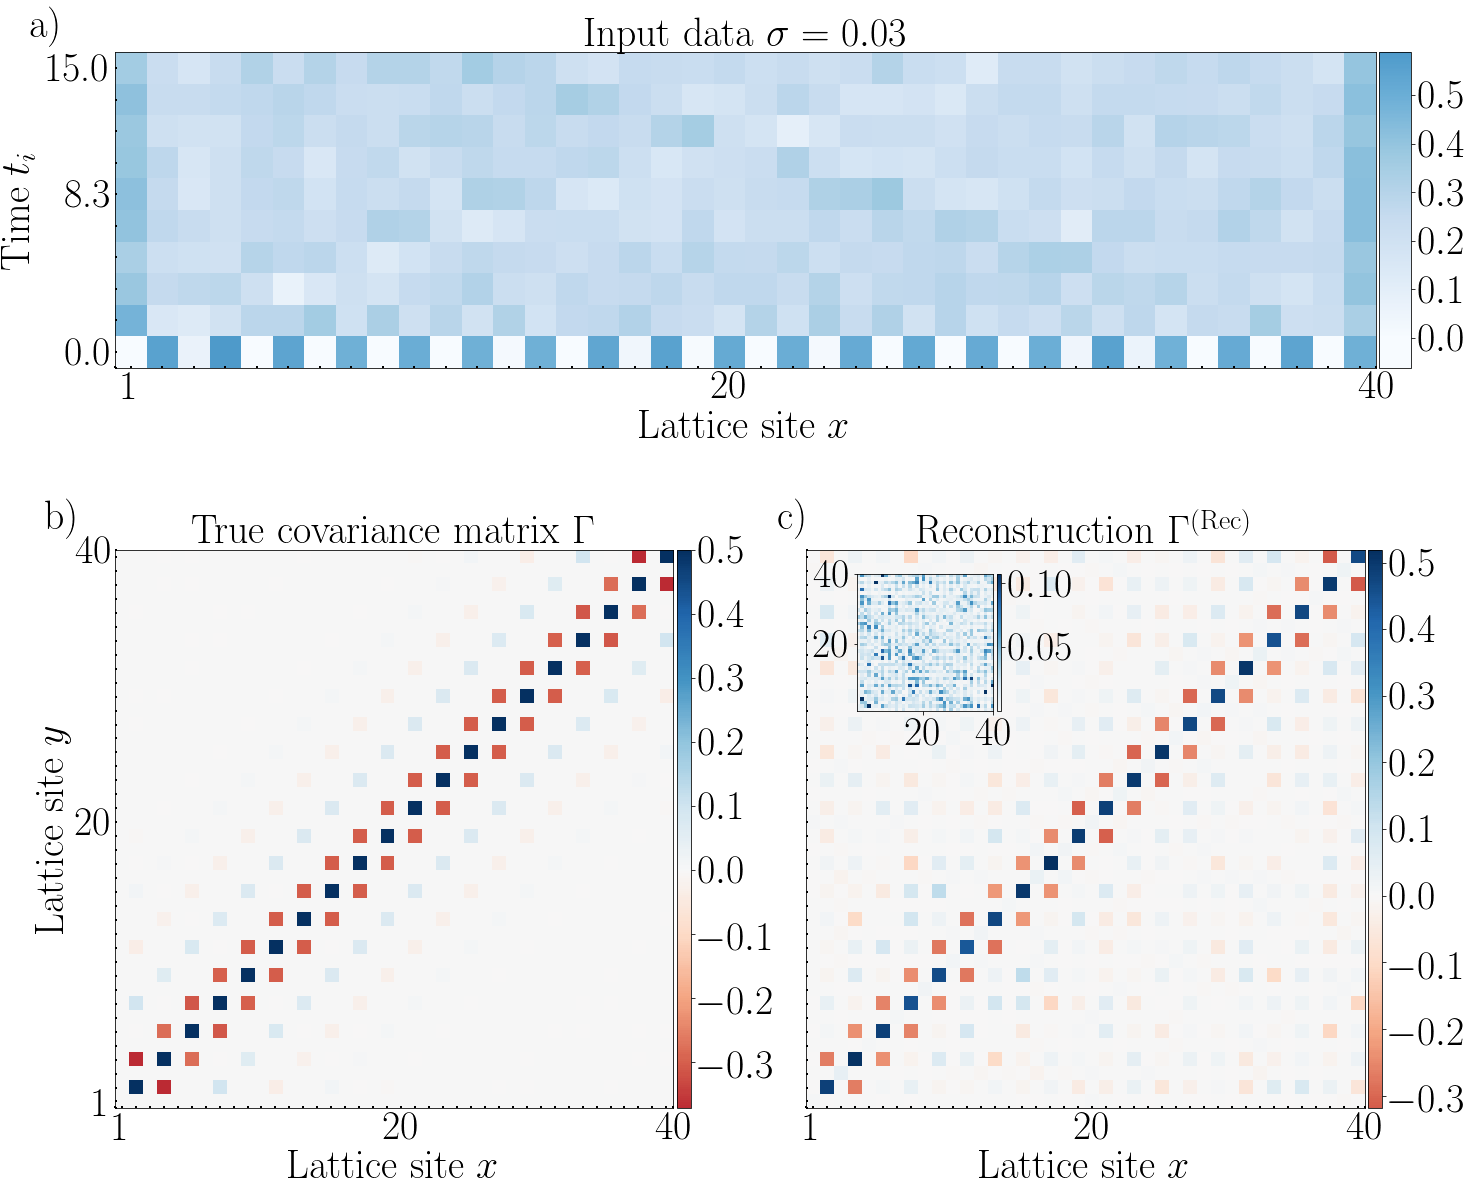

In [110]:
LL=tomography.LL
save_path = 'figs/tomography_main_L_'+str(L)+'_T_'+str(T)+'_N_'+str(N)+'_sigma_'+str( int( np.ceil(sigma) ) )+'.pdf'

fontsize = 40
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.size'] = fontsize
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.labelspacing'] = .3
plt.rcParams['legend.columnspacing']= .3
plt.rcParams['legend.handletextpad']= .1
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
#Main plot
fig = plt.figure( figsize = ( 20,20 ) )

data_pos_x  = 0.06
data_pos_y = .53
data_height = 0.4
data_width = 0.9

ini_pos_x  = 0.06
ini_pos_y = .1
ini_height = 0.4
ini_width = ini_height

rec_pos_x  = 0.54
rec_pos_y = .1
rec_height = 0.4
rec_width = rec_height

inset_pos_x = 0.575
inset_pos_y = 0.38   
inset_height = 0.1
inset_width = 0.1

label_a_x = -2.7
label_a_y = 1.05*N
label_b_x = -5
label_b_y = LL+1.5   
label_c_x = -2
label_c_y = label_b_y

## a)
#Input data
ax_input_data = fig.add_axes( [ data_pos_x, data_pos_y, data_width, data_height ] )   

im_input_data = ax_input_data.imshow( data, cmap='Blues', aspect = 'auto', interpolation = None, 
                                     extent= [0, LL, N, 0])
plt.text( label_a_x,label_a_y, 'a)')

title = r'Input data $\sigma = %0.2f$' % sigma
plt.title( title )
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Time $t_i$' )
plt.clabel = r'$N_x(t)$'

#plt.grid() 

plt.xlim((0,LL))
N = len( times )        
plt.ylim((0,N))

ticks = np.append(0,np.linspace(0.5,LL-.5,LL))
ticks = np.append(ticks, LL)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[int(LL/2)] = int(LL/2)
tick_labels[-1] = LL
plt.xticks(np.array(ticks),tick_labels)

ticks = np.append(0,np.linspace(.5,N-.5,N))
np.append(ticks,N)
tick_labels = ['']*(len(ticks))
tick_labels[1] = times[0]
tick_labels[int(N/2)+1] = round(times[int(N/2)],1)
tick_labels[-1] = times[-1]
plt.yticks(np.array(ticks),tick_labels)

ax_input_data.tick_params(direction='in', length=2, width=2, colors='k')#,    grid_color='k', grid_alpha=0.5)

divider = make_axes_locatable(ax_input_data)
cax = divider.append_axes("right", size="2.5%", pad=0.05)        
cbar = plt.colorbar(im_input_data, cax=cax)
cbar.set_clim( 0, 1 )
ax_input_data.set_aspect(1)

## b)
#Plot cov_ini
ax_cov_ini = fig.add_axes( [ ini_pos_x, ini_pos_y, ini_width, ini_height ] )

im_cov_ini = ax_cov_ini.imshow( (cov_ini), cmap='RdBu', aspect='equal', interpolation = None, 
                               extent = [ 0, LL, LL, 0])
plt.text( label_b_x,label_b_y, 'b)')

title = r'True covariance matrix $\Gamma$'
plt.title( title )
plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Lattice site $y$' )
#plt.grid()
ticks = np.append(0,np.linspace(0.5,LL-.5,LL))
ticks = np.append(ticks,LL)
tick_labels = ['']*(len(ticks))
tick_labels[1] = 1
tick_labels[int(LL/2)+1] = int(LL/2)
tick_labels[-1] = LL

plt.xticks(np.array(ticks),tick_labels)
plt.yticks(np.array(ticks),tick_labels)
ax_cov_ini.tick_params(direction='in', length=2, width=2, colors='k')
divider = make_axes_locatable(ax_cov_ini)
cax = divider.append_axes("right", size="2.5%", pad=0.05)

cbar = plt.colorbar(im_cov_ini, cax=cax)
range_plot = np.max( np.abs( cov_ini ) )
cbar.set_clim( -range_plot, range_plot )

## c)
#Plot cov reconstructed + inset deviation

ax_cov_rec = fig.add_axes( [ rec_pos_x, rec_pos_y, rec_width, rec_height ] )
cov_rec = (tomography.Gamma)
inset_cov = abs( cov_ini - tomography.Gamma )
im_cov_rec = ax_cov_rec.imshow( cov_rec.real, cmap='RdBu', aspect='equal', interpolation = None, 
                               extent = [ 0, LL, LL, 0])
plt.text( label_c_x,label_c_y, 'c)')

title = r'Reconstruction $\Gamma^{\rm(Rec)}$'
plt.title( title )
#plt.grid()
plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )
plt.xticks(np.array(ticks),tick_labels)
plt.yticks(ticks,[])
ax_cov_rec.tick_params(direction='in', length=2, width=2, colors='k')

divider = make_axes_locatable( ax_cov_rec )
cax_cov_rec = divider.append_axes("right", size="2.5%", pad=0.05)

cbar = plt.colorbar( im_cov_rec, cax = cax_cov_rec )
range_plot = np.max( np.abs( cov_rec ) )
cbar.set_clim( -range_plot, range_plot )

#inset 
inset = fig.add_axes( [ inset_pos_x, inset_pos_y, inset_width, inset_height ] )
im2 = inset.imshow( inset_cov, extent = [ 1, LL, LL, 1], cmap='RdBu', aspect='equal', interpolation = None)
plt.xlim((1,LL))
plt.ylim((1,LL))
divider2 = make_axes_locatable(inset)
cax_cov_rec2 = divider2.append_axes("right", size="2.5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax = cax_cov_rec2 )
range_plot = np.max( np.abs( inset_cov ) )
cbar2.set_clim( -range_plot, range_plot )
cbar2.set_ticks( [ round(range_plot,1)/2,round(range_plot,1)])

plt.savefig( save_path, format='pdf')
plt.show()


In [83]:
ticks = np.append(0,np.linspace(.5,N-.5,N))
np.append(ticks,N)

array([ 0. ,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15. ])

In [95]:
times

array([ 0.  ,  3.75,  7.5 , 11.25, 15.  ])

In [11]:
data2 = [ H_quench.cov_evolve( tomography.Gamma, t ).real.diagonal(0) 
         -H_quench.cov_evolve( cov_ini, t ).real.diagonal(0)for t in times ]
np.linalg.norm(data2)

1.3785700473380349e-05

In [48]:
np.linspace(0.5,LL-.5,LL)

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
       22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
       33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5])

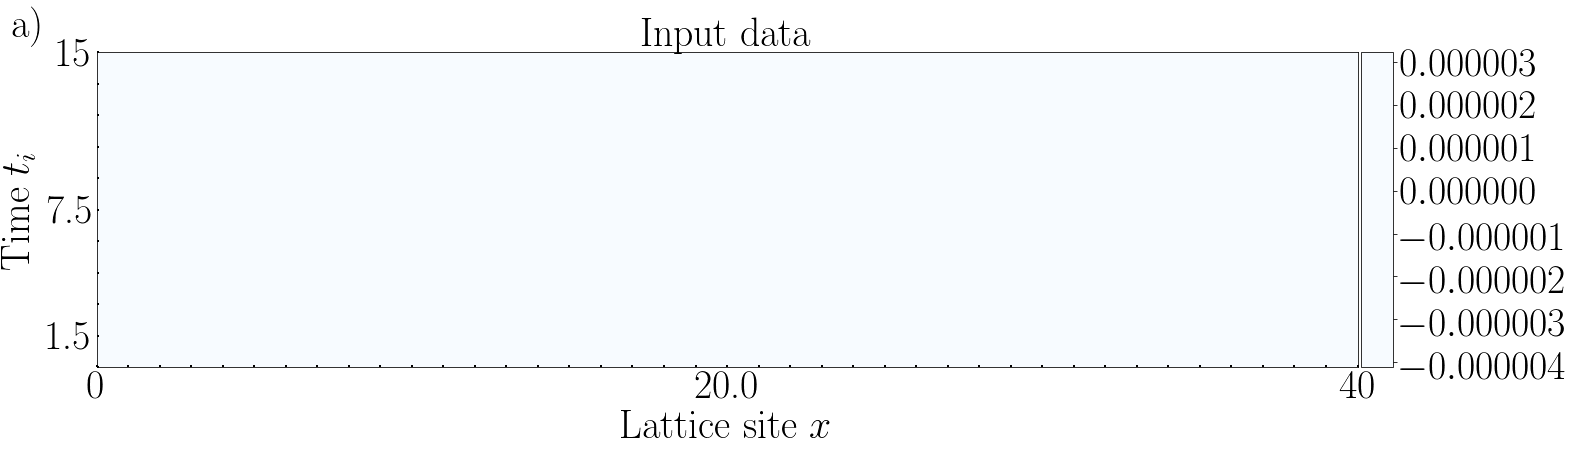

In [98]:
L=40
save_path = 'figs/tomography_double_check_L_'+str(L)+'_T_'+str(T)+'_N_'+str(N)+'_sigma_'+str( int( np.ceil(sigma) ) )+'.pdf'

fontsize = 40
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.size'] = fontsize

#Main plot
fig = plt.figure( figsize = ( 20,20 ) )

data_pos_x  = 0.06
data_pos_y = .49
data_height = 0.4
data_width = 0.9

ini_pos_x  = 0.06
ini_pos_y = .1
ini_height = 0.4
ini_width = ini_height

rec_pos_x  = 0.54
rec_pos_y = .1
rec_height = 0.4
rec_width = rec_height

inset_pos_x = 0.57
inset_pos_y = 0.335   
inset_height = 0.15
inset_width = 0.15

label_a_x = -2.7
label_a_y = 10.5
label_b_x = -5
label_b_y = 51   
label_c_x = -3
label_c_y = 51

## a)
#Input data
ax_input_data = fig.add_axes( [ data_pos_x, data_pos_y, data_width, data_height ] )   


plt.text( label_a_x,label_a_y, 'a)')


im_input_data = ax_input_data.imshow( data2, cmap='Blues', aspect = 'auto', interpolation = None, 
                                     extent= [0, L, N, 0])

title = r'Input data'
plt.title( title )
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Time $t_i$' )
plt.clabel = r'$N_x(t)$'

#plt.grid() 

plt.xlim((0,L))
N = len( times )        
plt.ylim((0,N))

xlabels = ['']*(L+1)
xlabels[0]='0'
xlabels[-1]=(L)
xlabels[int(L/2)] =(L/2)
ylabels = ['']*(N+1)
ylabels[1]=T/N
ylabels[-1]=T
ylabels[int(N/2)]= ( (T/2))
#ylabels[5]= ( (T/2))

plt.xticks( range(0,L+1),xlabels )
plt.yticks( range(0,N+1), ylabels)

ax_input_data.tick_params(direction='in', length=2, width=2, colors='k')#,    grid_color='k', grid_alpha=0.5)

divider = make_axes_locatable(ax_input_data)
cax = divider.append_axes("right", size="2.5%", pad=0.05)        
cbar = plt.colorbar(im_input_data, cax=cax)
cbar.set_clim( 0, 1 )
ax_input_data.set_aspect(1)




plt.savefig( save_path, format='pdf')
plt.show()


----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1806015
eps = 1.00e-05, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 3815, constraints m = 8895
Cones:	soc vars: 2415, soc blks: 615
	sd vars: 6480, sd blks: 2
Setup time: 4.62e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.92e+20  4.19e+20  9.84e-01 -7.62e+21 -6.27e+19  5.63e+21  1.08e-01 
   100| 8.62e-05  7.20e-05  7.25e-05 -1.31e-05 -8.57e-05  8.10e-16  3.70e+00 
   200| 3.21e-05  2.01e-05  9.74e-06 -1.38e-07 -9.88e-06  2.55e-16  7.66e+00 
  